# RNN prediction for Bitcoin value
From our processed data mart we are using a specific view for Bitcoin data and performing time series prediction using RNN method. Recurrant Neural Networks are used to handle sequence dependance and can be used for time series       prediction. In this analysis method we are using Keras deep learning library to demonstrate time series prediction.

In [ ]:
# Importing Libraries
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import sqlalchemy

In [ ]:
#Using data from AWS RDS which is the data warehouse
username = "postgres"
password = "postgres"
endpoint = "crypto-warehouse.cdvabacdldda.us-west-1.rds.amazonaws.com" 
dbname   = "BitcoinDataMart"

con = sqlalchemy.create_engine("postgresql://%s:%s@%s/%s" % (username, password, endpoint, dbname))

df = pd.read_sql("SELECT * FROM bitcoin_datamart_data", con)
#print(pd.__version__)
df.head()

,column1,unix,Open,high,low,Close,volume-coin,volume-usd,weighted_price,date,just_date,just_time
0,0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:52:00,2011-12-31,07:52:00
1,1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:53:00,2011-12-31,07:53:00
2,2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:54:00,2011-12-31,07:54:00
3,3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:55:00,2011-12-31,07:55:00
4,4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:56:00,2011-12-31,07:56:00


In [ ]:
# Changing date and time values from epoch time to datetime.
df['weighted_price'] = df['weighted_price'].astype(float)

df['date'] = pd.to_datetime(df['unix'],unit='s').dt.date

group = df.groupby('date')

Real_Price = group['weighted_price'].mean()


# Pulled and processed dataset may not have weighted average values, so here I am calculating the weighed average. This value us the average proce of the asset for a given peried weighted by volume.
#This value will be used for RNN prediction.

df['my_weighted_avg'] = df[['high','low','Close']].mean(axis=1)
df.head()

,column1,unix,Open,high,low,Close,volume-coin,volume-usd,weighted_price,date,just_date,just_time,my_weighted_avg
0,0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31,2011-12-31,07:52:00,4.39
1,1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31,2011-12-31,07:53:00,NaN
2,2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31,2011-12-31,07:54:00,NaN
3,3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31,2011-12-31,07:55:00,NaN
4,4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31,2011-12-31,07:56:00,NaN


In [ ]:
# split data for train and test
prediction_days = 30
df_train= Real_Price[:len(Real_Price)-prediction_days]
df_test= Real_Price[len(Real_Price)-prediction_days:]


In [ ]:
# Data preprocess
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [ ]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling  RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

Epoch 1/100
669/669 [==============================] - 2s 2ms/step - loss: 0.0160
Epoch 2/100
669/669 [==============================] - 1s 2ms/step - loss: 0.0134
Epoch 3/100
669/669 [==============================] - 1s 2ms/step - loss: 0.0124
Epoch 4/100
669/669 [==============================] - 1s 2ms/step - loss: 0.0107
Epoch 5/100
669/669 [==============================] - 1s 2ms/step - loss: 0.0082
Epoch 6/100
669/669 [==============================] - 1s 2ms/step - loss: 0.0052
Epoch 7/100
669/669 [==============================] - 1s 2ms/step - loss: 0.0025
Epoch 8/100
669/669 [==============================] - 1s 2ms/step - loss: 8.5233e-04
Epoch 9/100
669/669 [==============================] - 1s 2ms/step - loss: 2.5579e-04
Epoch 10/100
669/669 [==============================] - 1s 2ms/step - loss: 1.4468e-04
Epoch 11/100
669/669 [==============================] - 1s 2ms/step - loss: 1.2571e-04
Epoch 12/100
669/669 [==============================] - 1s 2ms/step - loss: 1.10

In [ ]:
# Making predictions for BTC
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)



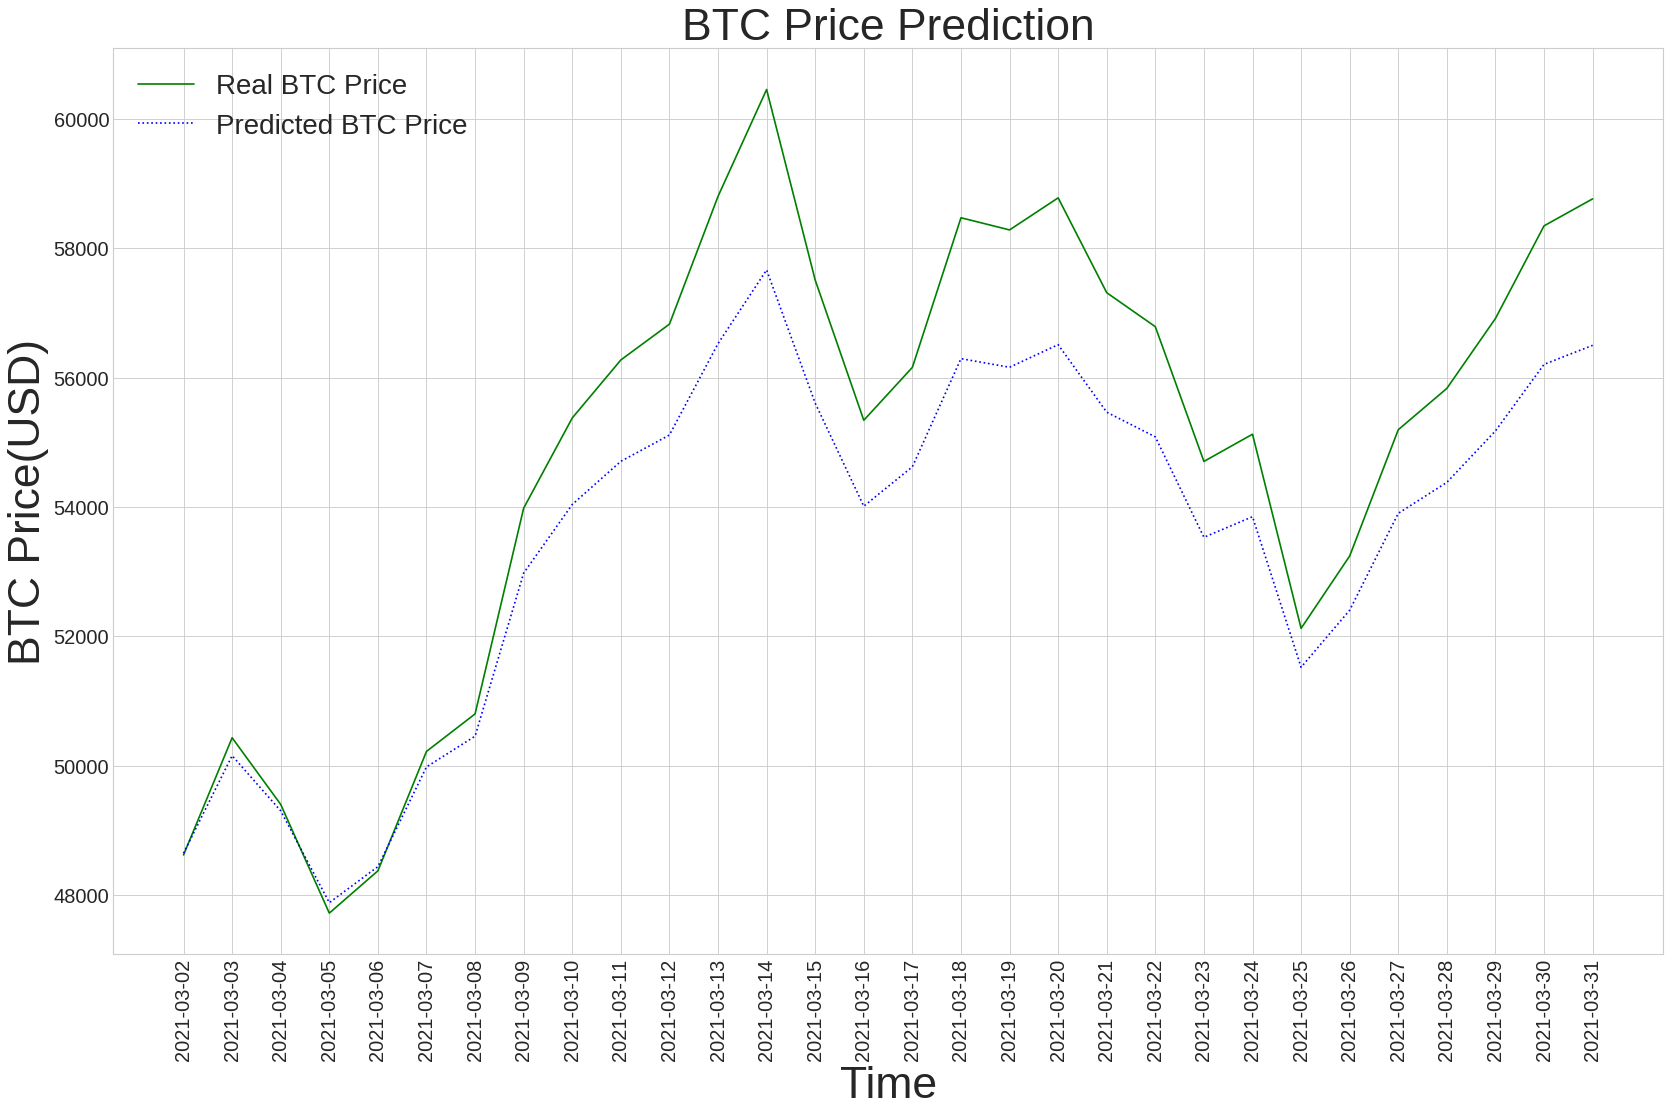

In [ ]:

# Visualising the results
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set,'-g', label = 'Real BTC Price')
plt.plot(predicted_BTC_price,':b', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()



Bitcoin value is predicted for the last 30 days and we see that prediction is colse to the actual values.
